# 2. Extra Trees Classifier

Using the baseline results from the EDA notebook, we can see that the Extra Trees Classifier is the best performing model. We will now perform further exploration of this model to see if we can improve the results using feature engineering.

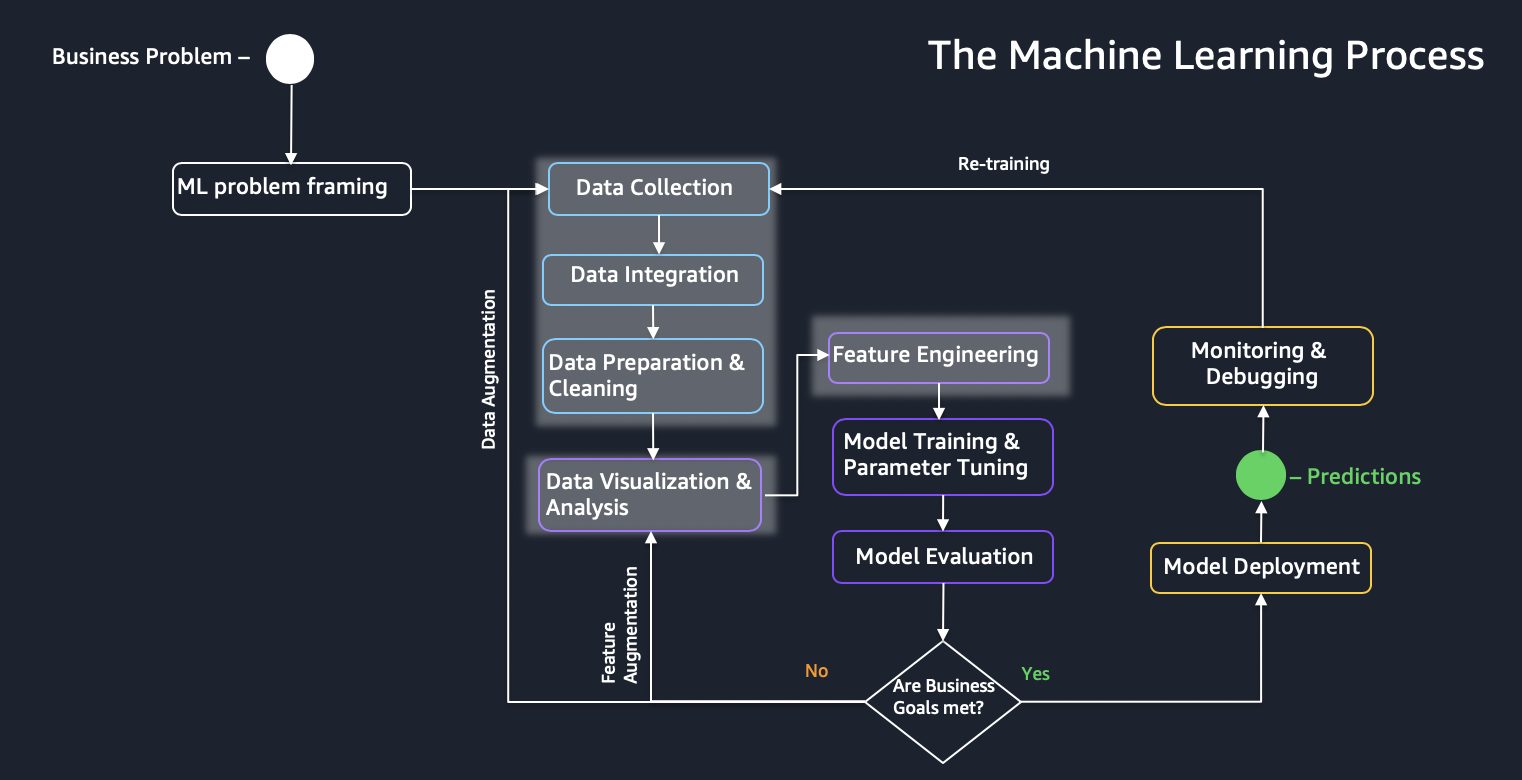
_source: SageMaker Studio Immersion Day_

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from fast_ml.feature_engineering import FeatureEngineering_DateTime
from pycaret.classification import *
from sklearn.metrics import classification_report

## 2.1 Data Preparation & Cleaning

### 2.1.1 Load Source Data

_Constante, Fabian; Silva, Fernando; Pereira, António (2019), “DataCo SMART SUPPLY CHAIN FOR BIG DATA ANALYSIS”, Mendeley Data, V5, doi: 10.17632/8gx2fvg2k6.5_

In [2]:
# load the source data
df_source = pd.read_csv('data/raw/DataCoSupplyChainDataset.csv', encoding='unicode_escape')
df_source.drop_duplicates(inplace=True)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head())

(180519, 53)


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [3]:
df_source['Customer Email'].value_counts()

XXXXXXXXX    180519
Name: Customer Email, dtype: int64

In [4]:
df_source['Customer Password'].value_counts()

XXXXXXXXX    180519
Name: Customer Password, dtype: int64

In [5]:
print('--- Customer Zipcode ---')
print('dtype:', df_source.dtypes['Customer Zipcode'])
print('unique:', df_source['Customer Zipcode'].value_counts().size)
print('null:', df_source['Customer Zipcode'].isnull().sum())


--- Customer Zipcode ---
dtype: float64
unique: 995
null: 3


In [6]:
df_source['Latitude'].value_counts()

18.227573    417
39.495914    370
18.227577    300
36.910831    280
26.098499    270
            ... 
18.246769      1
18.214268      1
18.253412      1
18.287685      1
18.242485      1
Name: Latitude, Length: 11250, dtype: int64

In [7]:
df_source[df_source['Customer Id'] != df_source['Order Customer Id']].shape

(0, 53)

### 2.1.2 Add the Target Variable

In [8]:
def add_is_fraud(df_data: pd.DataFrame) -> pd.DataFrame:
    """
    Add a new column to the dataframe that indicates
    0: No Fraud and 1: Fraud

    Parameters
    ----------
    df_data : pd.DataFrame
        The source dataframe
    """
    df_data['is_fraud'] = df_data['Order Status'].apply(lambda x: 1 if x == 'SUSPECTED_FRAUD' else 0)
    return df_data

df_data = df_source.reset_index(drop=True)
add_is_fraud(df_data)
df_data['is_fraud'].value_counts()

0    176457
1      4062
Name: is_fraud, dtype: int64

In [9]:
# is fraud and shipping canceled
print('Shipping canceled           :', df_data[df_data['Delivery Status'] == 'Shipping canceled'].shape[0])
print('Fraud and Shipping canceled :', df_data[(df_data['is_fraud'] == 1) & (df_data['Delivery Status'] == 'Shipping canceled')].shape[0])

Shipping canceled           : 7754
Fraud and Shipping canceled : 4062


### 2.1.3. Remove the columns that will not be used in the model

In [10]:
remove_column_list = [
    'Category Id',              # Details at product level are not used in this analysis
    'Category Name',            #   .
    'Customer Email',           # The data has been anonymized and the email is not useful
    'Customer Fname',           # The Customer Id is enough and the first name is not useful
    'Customer Lname',           # The Customer Id is enough and the last name is not useful
    'Customer Password',        # The data has been anonymized and the password is not useful
    'Customer Street',          # The Customer Zipcode is enough and the street is not useful
    'Department Name',          # The Department Id is enough and the name is not useful
    'Order Customer Id',        # The Customer Id is the same as the Order Customer Id
    'Order Item Cardprod Id',   # Item level details are not used in this analysis
    'Order Item Discount',      #   although this data may be useful for future analysis
    'Order Item Discount Rate', #   where, for example, the order quantity could be
    'Order Item Id',            #   useful in fraud detection.
    'Order Item Product Price', #   .
    'Order Item Profit Ratio',  #   .
    'Order Item Quantity',      #   .
    'Order Item Total',         #   .
    'Product Card Id',          # Product details are not used in this analysis although
    'Product Category Id',      #   this data may be useful for future analysis as
    'Product Description',      #   some products might be more likely to targeted for
    'Product Image',            #   fraud.
    'Product Name',             #   .
    'Product Price',            #   .
    'Product Status',           #   .
    
    'Order Status',             # The target value is derived from this column
    'Delivery Status',          # Data leakage: suspected fraud orders are all cancelled

]

In [11]:
df_data = df_data \
    .drop(columns=remove_column_list) \
    .drop_duplicates() \
    .reset_index(drop=True)

print(df_data.shape)
with pd.option_context('display.max_columns', None):
    display(df_data.head())

(180519, 28)


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Customer City,Customer Country,Customer Id,Customer Segment,Customer State,Customer Zipcode,Department Id,Latitude,Longitude,Market,Order City,Order Country,order date (DateOrders),Order Id,Sales,Order Profit Per Order,Order Region,Order State,Order Zipcode,shipping date (DateOrders),Shipping Mode,is_fraud
0,DEBIT,3,4,91.250000,314.640015,0,Caguas,Puerto Rico,20755,Consumer,PR,725.0,2,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,1/31/2018 22:56,77202,327.75,91.250000,Southeast Asia,Java Occidental,NaN,2/3/2018 22:56,Standard Class,0
1,TRANSFER,5,4,-249.089996,311.359985,1,Caguas,Puerto Rico,19492,Consumer,PR,725.0,2,18.279451,-66.037064,Pacific Asia,Bikaner,India,1/13/2018 12:27,75939,327.75,-249.089996,South Asia,Rajastán,NaN,1/18/2018 12:27,Standard Class,0
2,CASH,4,4,-247.779999,309.720001,0,San Jose,EE. UU.,19491,Consumer,CA,95125.0,2,37.292233,-121.881279,Pacific Asia,Bikaner,India,1/13/2018 12:06,75938,327.75,-247.779999,South Asia,Rajastán,NaN,1/17/2018 12:06,Standard Class,0
3,DEBIT,3,4,22.860001,304.809998,0,Los Angeles,EE. UU.,19490,Home Office,CA,90027.0,2,34.125946,-118.291016,Pacific Asia,Townsville,Australia,1/13/2018 11:45,75937,327.75,22.860001,Oceania,Queensland,NaN,1/16/2018 11:45,Standard Class,0
4,PAYMENT,2,4,134.210007,298.250000,0,Caguas,Puerto Rico,19489,Corporate,PR,725.0,2,18.253769,-66.037048,Pacific Asia,Townsville,Australia,1/13/2018 11:24,75936,327.75,134.210007,Oceania,Queensland,NaN,1/15/2018 11:24,Standard Class,0


### 2.1.4. Summarize by Order

In [12]:
def find_item_level_columns(df_data : pd.DataFrame, unique_order_count: int) -> list:
    """
    Find the columns in the dataset that are still at item level.

    Parameters
    ----------
    df_data : pd.DataFrame
        The dataset to be analyzed.
    unique_order_count : int
        The number of unique orders in the dataset.

    Returns
    -------
    list
        The list of columns that are still at item level.
    """
    id = 'Order Id'
    item_columns = []

    for column in df_data.columns:
        if column == id:
            continue

        subset_count = df_data[[id, column]].drop_duplicates().shape[0]

        if subset_count != unique_order_count:
            item_columns.append([column, subset_count])

    return np.array(item_columns)

In [13]:
unique_order_count = df_data['Order Id'].value_counts().count()
print('unique order count:', unique_order_count)

unique order count: 65752


In [14]:
item_level_columns = find_item_level_columns(df_data, unique_order_count)
item_level_columns

array([['Benefit per order', '180459'],
       ['Sales per customer', '180491'],
       ['Department Id', '131644'],
       ['Sales', '168922'],
       ['Order Profit Per Order', '180459']], dtype='<U22')

In [15]:
# remove the columns that are still at item level to have only order level data
df_data = df_data \
    .drop(columns=item_level_columns[:,0]) \
    .drop_duplicates() \
    .reset_index(drop=True)

print(df_data.shape)
with pd.option_context('display.max_columns', None):
    display(df_data.head())

(65752, 23)


,Type,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Customer City,Customer Country,Customer Id,Customer Segment,Customer State,Customer Zipcode,Latitude,Longitude,Market,Order City,Order Country,order date (DateOrders),Order Id,Order Region,Order State,Order Zipcode,shipping date (DateOrders),Shipping Mode,is_fraud
0,DEBIT,3,4,0,Caguas,Puerto Rico,20755,Consumer,PR,725.0,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,1/31/2018 22:56,77202,Southeast Asia,Java Occidental,NaN,2/3/2018 22:56,Standard Class,0
1,TRANSFER,5,4,1,Caguas,Puerto Rico,19492,Consumer,PR,725.0,18.279451,-66.037064,Pacific Asia,Bikaner,India,1/13/2018 12:27,75939,South Asia,Rajastán,NaN,1/18/2018 12:27,Standard Class,0
2,CASH,4,4,0,San Jose,EE. UU.,19491,Consumer,CA,95125.0,37.292233,-121.881279,Pacific Asia,Bikaner,India,1/13/2018 12:06,75938,South Asia,Rajastán,NaN,1/17/2018 12:06,Standard Class,0
3,DEBIT,3,4,0,Los Angeles,EE. UU.,19490,Home Office,CA,90027.0,34.125946,-118.291016,Pacific Asia,Townsville,Australia,1/13/2018 11:45,75937,Oceania,Queensland,NaN,1/16/2018 11:45,Standard Class,0
4,PAYMENT,2,4,0,Caguas,Puerto Rico,19489,Corporate,PR,725.0,18.253769,-66.037048,Pacific Asia,Townsville,Australia,1/13/2018 11:24,75936,Oceania,Queensland,NaN,1/15/2018 11:24,Standard Class,0


### 2.1.5 Configure Data Types

In [16]:
# convert datetime columns to datetime type
df_data['order date (DateOrders)'] = pd.to_datetime(df_data['order date (DateOrders)'])
df_data['shipping date (DateOrders)'] = pd.to_datetime(df_data['shipping date (DateOrders)'])

In [17]:
# get a list of the column data types
df_data.dtypes

Type                                     object
Days for shipping (real)                  int64
Days for shipment (scheduled)             int64
Late_delivery_risk                        int64
Customer City                            object
Customer Country                         object
Customer Id                               int64
Customer Segment                         object
Customer State                           object
Customer Zipcode                        float64
Latitude                                float64
Longitude                               float64
Market                                   object
Order City                               object
Order Country                            object
order date (DateOrders)          datetime64[ns]
Order Id                                  int64
Order Region                             object
Order State                              object
Order Zipcode                           float64
shipping date (DateOrders)       datetim

## 2.2 Data Visualization & Analysis

### 2.2.1. Correlation Matrix

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


<AxesSubplot:>

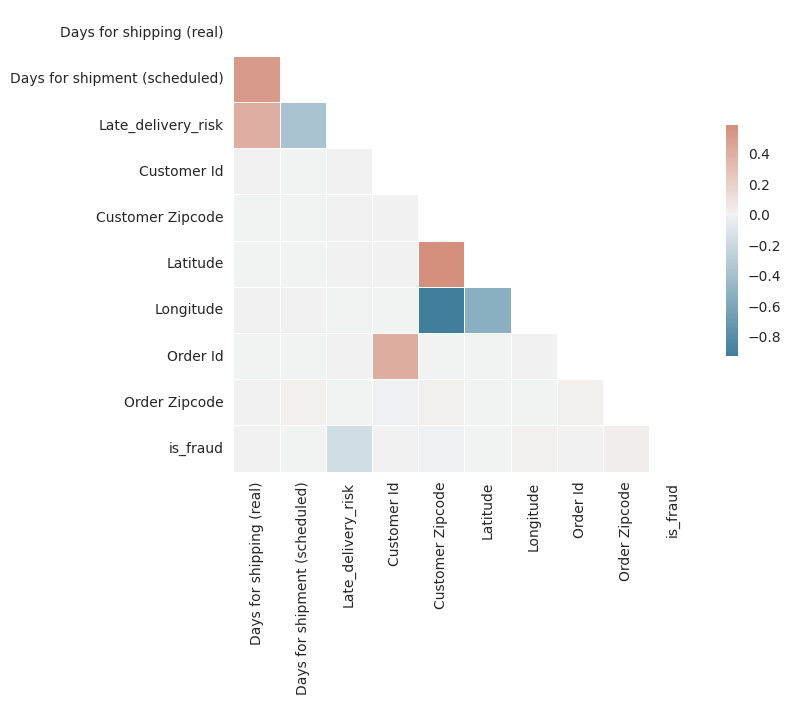

In [18]:
# Compute the correlation matrix
corr = df_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 2.3 Feature Engineering

### 2.3.2 Hour-Month

This variable is calculated based on the variable "order-date".

In [19]:
def add_hour_month(df_data: pd.DataFrame) -> pd.DataFrame:
    """
    Add a new column to the dataframe that indicates the time of the
    month in which this data was captured.

    Parameters
    ----------
    df_data : pd.DataFrame
        The source dataframe
    """
    df_data['hour-month'] = (df_data['order date (DateOrders)'].dt.day * 24) + df_data['order date (DateOrders)'].dt.hour
    return df_data

add_hour_month(df_data)
df_data['hour-month'].describe()

count    65752.000000
mean       389.792995
std        211.520715
min         24.000000
25%        207.000000
50%        390.000000
75%        572.000000
max        767.000000
Name: hour-month, dtype: float64

### 2.3.2 Date Features

Reference: [Feature Engineering of DateTime Variables](https://www.kaggle.com/code/nextbigwhat/feature-engineering-of-datetime-variables)

In [20]:
def add_date_features(
        df_data: pd.DataFrame,
        datetime_variables: list,
        prefix: str='default') -> pd.DataFrame:
    """
    Add date features to the dataframe.
    """
    dt_fe = FeatureEngineering_DateTime()
    dt_fe.fit(df_data, datetime_variables=datetime_variables, prefix=prefix)
    return dt_fe.transform(df_data)

In [21]:
# rename the datetime columns
df_data = df_data \
    .rename(columns={
        'order date (DateOrders)': 'order_date',
        'shipping date (DateOrders)': 'shipping_date',
    })

# add the date features
df_data = add_date_features(df_data, datetime_variables=['order_date'])
df_data = add_date_features(df_data, datetime_variables=['shipping_date'])

# remove the year columns as they may lead to overfitting
df_data = df_data \
    .drop(columns=[
        'order_date:year',
        'shipping_date:year'
    ])

# change ':' to '_' in the column names
df_data.columns = df_data.columns.str.replace(':', '_')

# remove the original datetime columns
df_data = df_data \
    .drop(columns=['order_date', 'shipping_date'])

with pd.option_context('display.max_columns', None):
    display(df_data.head())

,Type,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Customer City,Customer Country,Customer Id,Customer Segment,Customer State,Customer Zipcode,Latitude,Longitude,Market,Order City,Order Country,Order Id,Order Region,Order State,Order Zipcode,Shipping Mode,is_fraud,hour-month,order_date_quarter,order_date_month,order_date_day,order_date_day_of_week,order_date_day_of_year,order_date_weekofyear,order_date_is_month_end,order_date_is_month_start,order_date_is_quarter_end,order_date_is_quarter_start,order_date_is_year_end,order_date_is_year_start,order_date_time,order_date_hour,order_date_minute,order_date_second,order_date_is_weekend,order_date_day_part,shipping_date_quarter,shipping_date_month,shipping_date_day,shipping_date_day_of_week,shipping_date_day_of_year,shipping_date_weekofyear,shipping_date_is_month_end,shipping_date_is_month_start,shipping_date_is_quarter_end,shipping_date_is_quarter_start,shipping_date_is_year_end,shipping_date_is_year_start,shipping_date_time,shipping_date_hour,shipping_date_minute,shipping_date_second,shipping_date_is_weekend,shipping_date_day_part
0,DEBIT,3,4,0,Caguas,Puerto Rico,20755,Consumer,PR,725.0,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,77202,Southeast Asia,Java Occidental,NaN,Standard Class,0,766,1,1,31,2,31,5,True,False,False,False,False,False,22:56:00,22,56,0,0,night,1,2,3,5,34,5,False,False,False,False,False,False,22:56:00,22,56,0,1,night
1,TRANSFER,5,4,1,Caguas,Puerto Rico,19492,Consumer,PR,725.0,18.279451,-66.037064,Pacific Asia,Bikaner,India,75939,South Asia,Rajastán,NaN,Standard Class,0,324,1,1,13,5,13,2,False,False,False,False,False,False,12:27:00,12,27,0,1,noon,1,1,18,3,18,3,False,False,False,False,False,False,12:27:00,12,27,0,0,noon
2,CASH,4,4,0,San Jose,EE. UU.,19491,Consumer,CA,95125.0,37.292233,-121.881279,Pacific Asia,Bikaner,India,75938,South Asia,Rajastán,NaN,Standard Class,0,324,1,1,13,5,13,2,False,False,False,False,False,False,12:06:00,12,6,0,1,noon,1,1,17,2,17,3,False,False,False,False,False,False,12:06:00,12,6,0,0,noon
3,DEBIT,3,4,0,Los Angeles,EE. UU.,19490,Home Office,CA,90027.0,34.125946,-118.291016,Pacific Asia,Townsville,Australia,75937,Oceania,Queensland,NaN,Standard Class,0,323,1,1,13,5,13,2,False,False,False,False,False,False,11:45:00,11,45,0,1,noon,1,1,16,1,16,3,False,False,False,False,False,False,11:45:00,11,45,0,0,noon
4,PAYMENT,2,4,0,Caguas,Puerto Rico,19489,Corporate,PR,725.0,18.253769,-66.037048,Pacific Asia,Townsville,Australia,75936,Oceania,Queensland,NaN,Standard Class,0,323,1,1,13,5,13,2,False,False,False,False,False,False,11:24:00,11,24,0,1,noon,1,1,15,0,15,3,False,False,False,False,False,False,11:24:00,11,24,0,0,noon


## 2.4 Model Training & Parameter Tuning

### 12.4.1 Data Selection

In [22]:
# find columns with null values
has_nulls = df_data.columns[df_data.isna().any()].tolist()
print(has_nulls)

['Customer Zipcode', 'Order Zipcode', 'order_date_day_part', 'shipping_date_day_part']


In [23]:
random_state = 105

# create the training dataset
df_unseen = df_data.sample(frac=0.3, random_state=random_state)
df_train = df_data.drop(df_unseen.index)

# reset the index of both datasets
df_train.reset_index(drop=True, inplace=True)
df_unseen.reset_index(drop=True, inplace=True)

print(f'Training dataset shape : {df_train.shape}')
print(f'Unseen dataset shape   : {df_unseen.shape}')

Training dataset shape : (46026, 58)
Unseen dataset shape   : (19726, 58)


In [24]:
df_train.is_fraud.value_counts()

0    44986
1     1040
Name: is_fraud, dtype: int64

In [25]:
df_unseen.is_fraud.value_counts()

0    19278
1      448
Name: is_fraud, dtype: int64

### 12.4.2 Classifier Setup

In [26]:
classifier = setup(
    data=df_train,
    target='is_fraud',
    train_size=0.7,
    session_id=random_state,
    verbose=False)

### 12.4.3 Model Comparison

In [27]:
top_model = compare_models(exclude=['knn'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9785,0.9485,0.5440,0.5229,0.5325,0.5215,0.5220,1.2420
nb,Naive Bayes,0.9774,0.8539,0.0000,0.0000,0.0000,0.0000,0.0000,0.8810
ridge,Ridge Classifier,0.9774,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7230
rf,Random Forest Classifier,0.9774,0.8969,0.0000,0.0000,0.0000,0.0000,0.0000,1.1920
et,Extra Trees Classifier,0.9774,0.9508,0.0082,0.4500,0.0161,0.0153,0.0580,1.2640
dummy,Dummy Classifier,0.9774,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7380
ada,Ada Boost Classifier,0.9773,0.9528,0.0399,0.5508,0.0730,0.0698,0.1367,3.5240
lr,Logistic Regression,0.9771,0.5342,0.0000,0.0000,0.0000,-0.0006,-0.0018,2.6240
gbc,Gradient Boosting Classifier,0.9767,0.9502,0.0165,0.2417,0.0292,0.0270,0.0535,2.7280
dt,Decision Tree Classifier,0.9745,0.5395,0.0839,0.3222,0.1295,0.1209,0.1516,0.8230


[LightGBM] [Fatal] Feature (order_date_day_part_early_morning) appears more than one time.
[LightGBM] [Fatal] Feature (order_date_day_part_early_morning) appears more than one time.
[LightGBM] [Fatal] Feature (order_date_day_part_early_morning) appears more than one time.
[LightGBM] [Fatal] Feature (order_date_day_part_night) appears more than one time.
[LightGBM] [Fatal] Feature (order_date_day_part_early_morning) appears more than one time.
[LightGBM] [Fatal] Feature (order_date_day_part_early_morning) appears more than one time.
[LightGBM] [Fatal] Feature (order_date_day_part_early_morning) appears more than one time.
[LightGBM] [Fatal] Feature (order_date_day_part_early_morning) appears more than one time.
[LightGBM] [Fatal] Feature (order_date_day_part_early_morning) appears more than one time.
[LightGBM] [Fatal] Feature (order_date_day_part_early_morning) appears more than one time.
[LightGBM] [Fatal] Feature (order_date_day_part_early_morning) appears more than one time.
[LightG

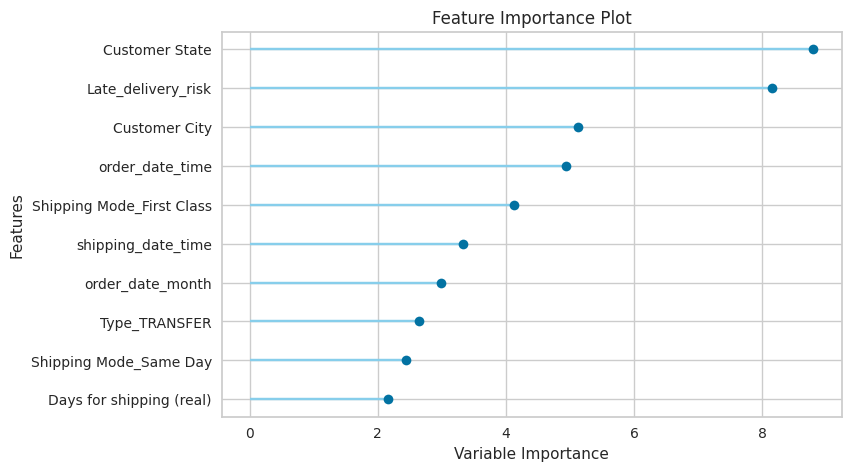

In [28]:
plot_model(top_model, plot='feature')

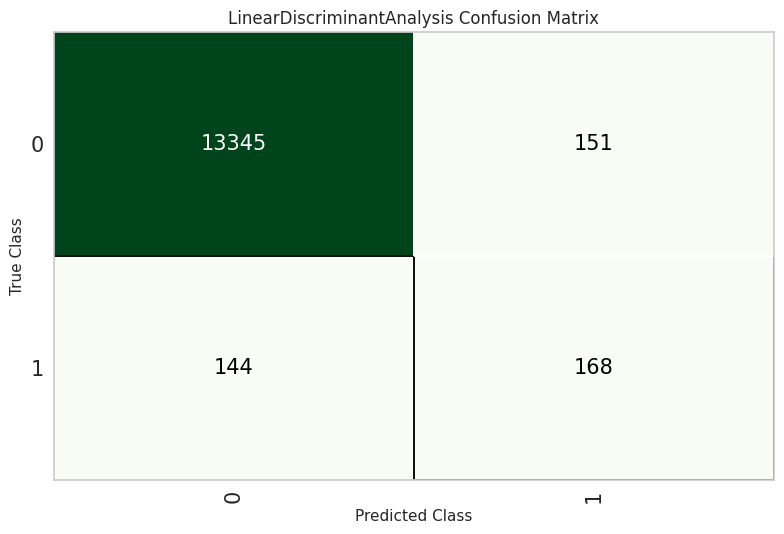

In [29]:
plot_model(top_model, plot='confusion_matrix')

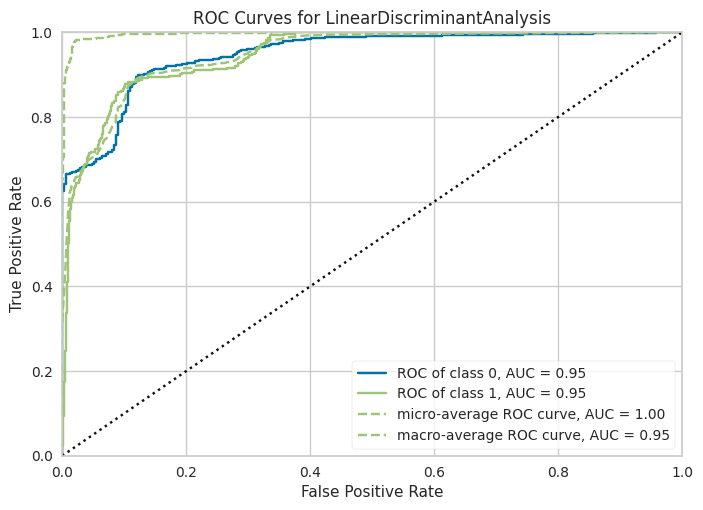

In [30]:
plot_model(top_model, plot='auc')

### 12.4.4 Extra Trees Classifier

In [31]:
et_classifier = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9770,0.9407,0.0000,0.0000,0.0000,-0.0006,-0.0027
1,0.9777,0.9568,0.0137,1.0000,0.0270,0.0264,0.1157
2,0.9780,0.9563,0.0274,1.0000,0.0533,0.0522,0.1637
3,0.9764,0.9516,0.0000,0.0000,0.0000,-0.0018,-0.0046
4,0.9777,0.9448,0.0137,1.0000,0.0270,0.0264,0.1157
5,0.9767,0.9427,0.0000,0.0000,0.0000,-0.0012,-0.0038
6,0.9777,0.9550,0.0137,1.0000,0.0270,0.0264,0.1157
7,0.9773,0.9564,0.0137,0.5000,0.0267,0.0255,0.0799
8,0.9776,0.9527,0.0000,0.0000,0.0000,0.0000,0.0000


In [41]:
tuned_et_classifier = tune_model(
    estimator=et_classifier,
    n_iter = 200,
    optimize='Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9767,0.9634,0.0959,0.4375,0.1573,0.1504,0.1969
1,0.9786,0.9684,0.1781,0.5909,0.2737,0.2660,0.3166
2,0.9792,0.9698,0.1644,0.6667,0.2637,0.2571,0.3244
3,0.9758,0.9545,0.1781,0.4194,0.2500,0.2397,0.2628
4,0.9789,0.9668,0.2603,0.5758,0.3585,0.3493,0.3781
5,0.9752,0.9549,0.1096,0.3478,0.1667,0.1575,0.1853
6,0.9808,0.9653,0.2466,0.7200,0.3673,0.3599,0.4144
7,0.9770,0.9604,0.1644,0.4800,0.2449,0.2361,0.2718
8,0.9770,0.9655,0.1528,0.4583,0.2292,0.2205,0.2555


Fitting 10 folds for each of 200 candidates, totalling 2000 fits


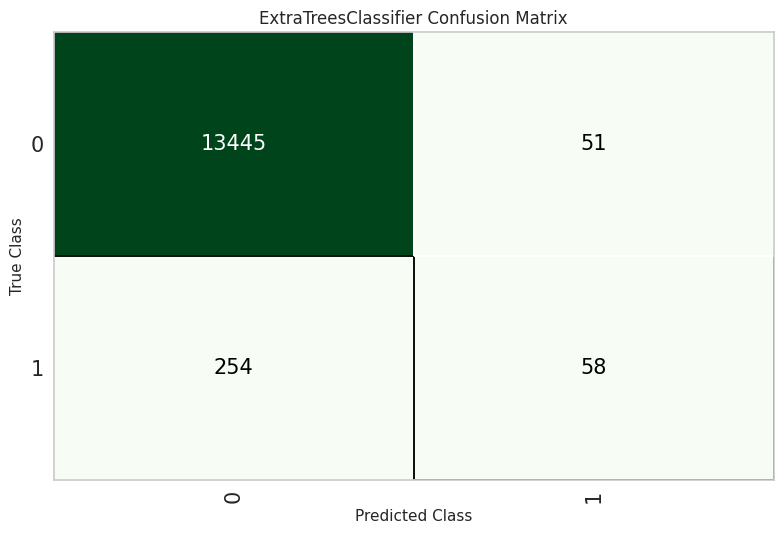

In [42]:
plot_model(tuned_et_classifier, plot='confusion_matrix')

In [44]:
tuned_et_classifier

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                     criterion='gini', max_depth=7, max_features=1.0,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.001, min_samples_leaf=4,
                     min_samples_split=10, min_weight_fraction_leaf=0.0,
                     n_estimators=220, n_jobs=-1, oob_score=False,
                     random_state=105, verbose=0, warm_start=False)

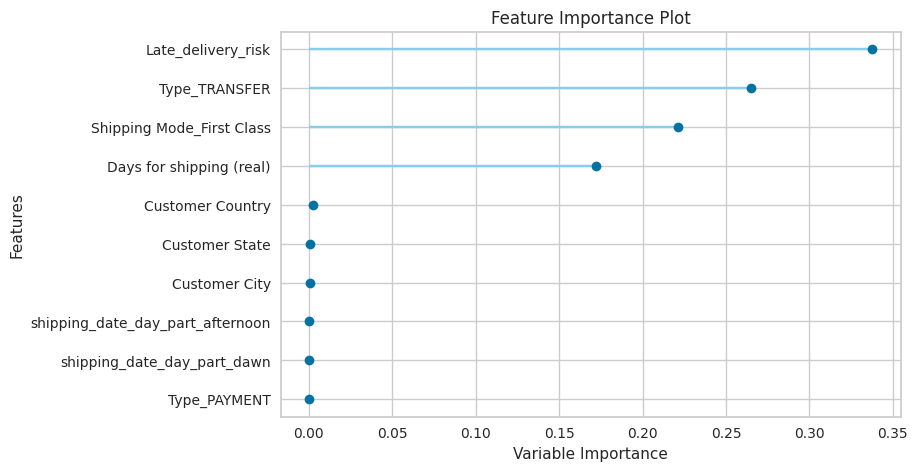

In [43]:
plot_model(tuned_et_classifier, plot='feature')

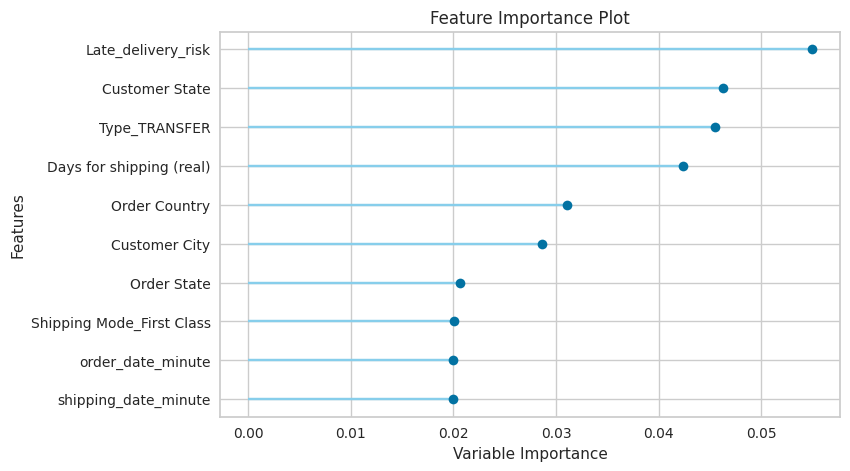

In [45]:
plot_model(et_classifier, plot='feature')

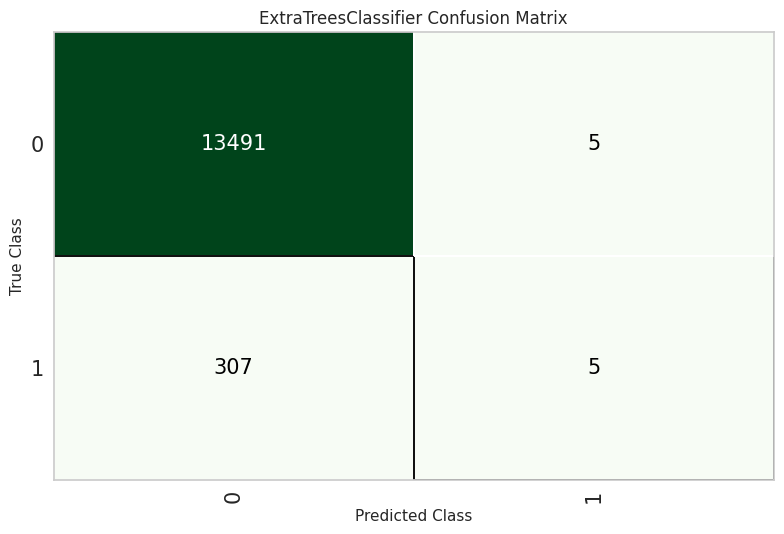

In [46]:
plot_model(et_classifier, plot='confusion_matrix')

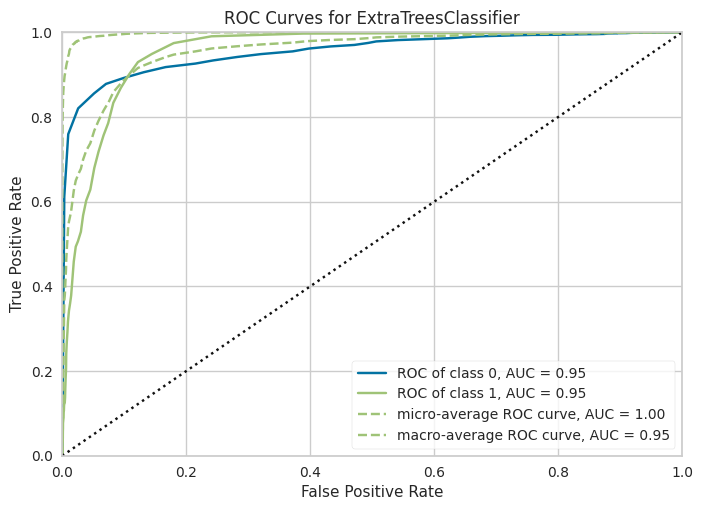

In [47]:
plot_model(et_classifier, plot='auc')

## 2.5 Model Evaluation

### 2.5.1 Auto ML

In [48]:
df_predicted = predict_model(estimator=top_model, data=df_unseen)
print(classification_report(y_true=df_predicted.is_fraud, y_pred=df_predicted.prediction_label))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.9783,0.9385,0.5134,0.5215,0.5174,0.5063,0.5063


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19278
           1       0.52      0.51      0.52       448

    accuracy                           0.98     19726
   macro avg       0.76      0.75      0.75     19726
weighted avg       0.98      0.98      0.98     19726



### 2.5.2 Extra Trees

In [49]:
df_predicted = predict_model(estimator=et_classifier, data=df_unseen)
print(classification_report(y_true=df_predicted.is_fraud, y_pred=df_predicted.prediction_label))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9777,0.9700,0.0268,0.8000,0.0518,0.0504,0.1439


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19278
           1       0.80      0.03      0.05       448

    accuracy                           0.98     19726
   macro avg       0.89      0.51      0.52     19726
weighted avg       0.97      0.98      0.97     19726



### 2.5.3 Tuned Extra Trees

In [50]:
df_predicted = predict_model(estimator=tuned_et_classifier, data=df_unseen)
print(classification_report(y_true=df_predicted.is_fraud, y_pred=df_predicted.prediction_label))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9775,0.9789,0.1518,0.5191,0.2349,0.2269,0.2724


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19278
           1       0.52      0.15      0.23       448

    accuracy                           0.98     19726
   macro avg       0.75      0.57      0.61     19726
weighted avg       0.97      0.98      0.97     19726

